In [5]:
# % Fig 5: fine-tuning metaparameters of "iterations"
# % 	- batch size effect on the iterations performance
# % 	- add/noadd & different ranking schemes effect
# % 	- comparison  of the best model with with docking-as-predictor
# % 	- TODO: comparison with the really best single model

# % How did we come up with iterations scheme:
# % 	- compared different train sizes
# % 	- compared different regimes (add/noadd)
# % 	- compared different ensembling methods
# % 	- compare with "docking-as-predictor"

# Imports

In [52]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

from matplotlib.ticker import AutoMinorLocator, MultipleLocator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tqdm.notebook import tqdm


def retrieve_iteration_size(df: pd.DataFrame) -> dict:
    possible_num_iterations = df.tot_num_of_iterations.unique()

    rv = {}
    for n_it in possible_num_iterations:
        subdf = df[df.tot_num_of_iterations == n_it]
        docked_sizes = subdf.docked_size.unique()
        differences = [abs(i - j) for i in docked_sizes for j in docked_sizes if i != j]
        rv[n_it] = min(differences)
    return rv


def add_iteration_size(df: pd.DataFrame):
    d = retrieve_iteration_size(df)
    df["iteration_size"] = df.apply({"tot_num_of_iterations": lambda x: d.get(x, None)})
    return df

# Import datasets and filter data

In [53]:
%%time

datasets = {
    'AmpC':'../data/AmpC_screen_table_1M/result_iterations_Morgan_size=2048_radius=2.csv',
    'D4'  :'../data/D4_screen_table_1M/result_iterations_Morgan_size=2048_radius=2.csv',
    '4eiy':'../data/4eiy_screen_table_1M/result_iterations_Morgan_size=2048_radius=2.csv',
    '5zty':'../data/5zty_screen_table_1M/result_iterations_Morgan_size=2048_radius=2.csv'
           }
dataset_size = {'AmpC':96214206, 'D4':138312677, '4eiy':int(1e6),'5zty':int(1e6)}

dfs = []
for name, path in tqdm(datasets.items()):
    df = pd.read_csv(path)
    df['proj'] = name
    df['N_ligands'] = dataset_size.get(name)
    dfs.append(df)

raw_data = pd.concat(dfs)

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 5.32 s, sys: 741 ms, total: 6.06 s
Wall time: 6.05 s


In [54]:
df = (
    raw_data.reset_index()
    .replace({"add": "True", "noadd": "False"})
    .drop(["index", "Unnamed: 0"], axis=1)
    .query("model == 'LinearRegression'")
    .query('prediction_method == "MeanRank"')
    .query("add_to_train == 'False'")
    .pipe(add_iteration_size)
)

In [55]:
df.sample(10)

,iteration,model,type,prediction_method,tot_num_of_iterations,add_to_train,docked_size,median_score,percentage_of_hits,added_molecules,proj,N_ligands,iteration_size
3772,19,LinearRegression,regressor,MeanRank,24,False,190000,-30.710000,79.593780,"['ZINC000344518490', 'ZINC000268459919', 'ZINC...",D4,138312677,10000
3757,4,LinearRegression,regressor,MeanRank,24,False,40000,-35.480000,38.892415,"['ZINC000277782783', 'ZINC000433032150', 'ZINC...",D4,138312677,10000
11012,16,LinearRegression,regressor,MeanRank,30,False,128000,-28.615070,64.311295,"['ZINC000044354790', 'ZINC000456913455', 'ZINC...",5zty,1000000,8000
10069,0,LinearRegression,regressor,MeanRank,24,False,0,-28.471300,1.391185,"['ZINC000809272805', 'ZINC000011039362', 'ZINC...",5zty,1000000,10000
3641,6,LinearRegression,regressor,MeanRank,8,False,180000,-29.890000,61.393209,"['ZINC000641802081', 'ZINC000555853284', 'ZINC...",D4,138312677,30000
9235,1,LinearRegression,regressor,MeanRank,30,False,8000,-28.760496,9.239654,"['ZINC001585275611', 'ZINC000847159682', 'ZINC...",4eiy,1000000,8000
832,0,LinearRegression,regressor,MeanRank,12,False,0,-65.830000,2.573333,"['ZINC000570540331', 'ZINC000416596846', 'ZINC...",AmpC,96214206,20000
2288,5,LinearRegression,regressor,MeanRank,30,False,40000,-65.990000,83.360000,"['ZINC000577266707', 'ZINC000294380675', 'ZINC...",AmpC,96214206,8000
6948,8,LinearRegression,regressor,MeanRank,24,False,80000,-28.510061,54.681699,"['ZINC000003301935', 'ZINC000731714506', 'ZINC...",4eiy,1000000,10000
3233,7,LinearRegression,regressor,MeanRank,24,False,70000,-33.770000,54.363694,"['ZINC000292123921', 'ZINC000534514300', 'ZINC...",D4,138312677,10000


In [56]:
df.tot_num_of_iterations.unique()

array([12, 30,  8, 24, 16,  6,  3,  2, 20])

# Try plotting everything on the single plot

Namely, I want to plot:
 - baseline-max -- "docking-as-predictor"
 - baseline-min -- "random score predictor"
 - extrapolation
 - real docking

In [57]:
dataset = "4eiy"
df = (
    raw_data.reset_index()
    .replace({"add": "True", "noadd": "False"})
    .drop(["index", "Unnamed: 0"], axis=1)
    .query('prediction_method == "MeanRank"')
    .query("add_to_train == 'False'")
    .query(f"proj == '{dataset}'")
    .pipe(add_iteration_size)
)

df = df[df.model.isin(("LinearRegression", "DockingAsPredictor"))]
df["baseline"] = df.docked_size * 0.01 / 100
df["iteration_num"] = df.docked_size // df.iteration_size

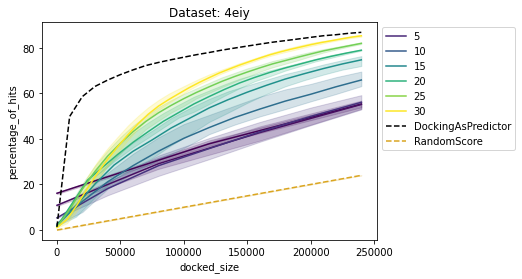

In [58]:
ax = sns.lineplot(
    data=df.query('model == "LinearRegression"'),
    x="docked_size",
    y="percentage_of_hits",
    hue="tot_num_of_iterations",
    palette="viridis",
)
sns.lineplot(
    ax=ax,
    data=(
        df.query('model == "DockingAsPredictor"').query("tot_num_of_iterations == 24")
    ),
    x="docked_size",
    y="percentage_of_hits",
    color="black",
    linestyle="--",
    label="DockingAsPredictor",
)
sns.lineplot(
    ax=ax,
    data=df,
    x="docked_size",
    y="baseline",
    color="goldenrod",
    linestyle="--",
    label="RandomScore",
)


# modify legend
for text in ax.get_legend().get_texts():
    new_texts = []
    if text.get_text() != "True":
        new_texts.append(text.get_text())
ax.set_title(f"Dataset: {dataset}")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Get the single-shot performance data


In [59]:
%%time

datasets = {
    'AmpC':'../data/AmpC_screen_table_1M/result_single_Morgan_size=2048_radius=2.csv',
    'D4'  :'../data/D4_screen_table_1M/result_single_Morgan_size=2048_radius=2.csv',
    '4eiy':'../data/4eiy_screen_table_1M/result_single_Morgan_size=2048_radius=2.csv',
    '5zty':'../data/5zty_screen_table_1M/result_single_Morgan_size=2048_radius=2.csv',
           }
dataset_size = {'AmpC':96214206, 'D4':138312677, '4eiy':int(1e6),'5zty':int(1e6)}

dfs = []
for name, path in tqdm(datasets.items()):
    tmp = pd.read_csv(path)
    tmp['proj'] = name
    tmp['N_ligands'] = dataset_size.get(name)
    dfs.append(tmp)

raw_data = pd.concat(dfs)

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 46.7 ms, sys: 7.37 ms, total: 54.1 ms
Wall time: 50.1 ms


In [60]:
project = "4eiy"
top_threshold = r"Hit(top 1.0%)"
model = "LinearRegression"

df_performance = (
    raw_data.query(f'proj == "{project}"')
    .query(f'top_threshold == "{top_threshold}"')
    .query(f'model == "{model}"')
)

In [61]:
df_performance.sort_values("train_size")

,Unnamed: 0,model,type,top_threshold,train_size,accuracy_score,precision_score,recall_score,TP+FP,docked,time_sec,fingerprints,TP,TN,FP,FN,proj,N_ligands
2010,1209,LinearRegression,regressor,Hit(top 1.0%),8000,0.983000,0.15000,0.15000,20,8020,1588,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000
1803,1002,LinearRegression,regressor,Hit(top 1.0%),8000,0.982000,0.10000,0.10000,20,8020,31,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000
1770,969,LinearRegression,regressor,Hit(top 1.0%),8000,0.984000,0.20000,0.20000,20,8020,46,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000
1707,906,LinearRegression,regressor,Hit(top 1.0%),8000,0.980000,0.00000,0.00000,20,8020,35,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000
1243,442,LinearRegression,regressor,Hit(top 1.0%),8000,0.982000,0.10000,0.10000,20,8020,51,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000
1778,977,LinearRegression,regressor,Hit(top 1.0%),40000,0.982800,0.14000,0.14000,100,40100,38,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000
1455,654,LinearRegression,regressor,Hit(top 1.0%),40000,0.982000,0.10000,0.10000,100,40100,34,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000
1365,564,LinearRegression,regressor,Hit(top 1.0%),40000,0.982800,0.14000,0.14000,100,40100,49,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000
1530,729,LinearRegression,regressor,Hit(top 1.0%),40000,0.981800,0.09000,0.09000,100,40100,35,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000
914,113,LinearRegression,regressor,Hit(top 1.0%),40000,0.982400,0.12000,0.12000,100,40100,205,Morgan,NaN,NaN,NaN,NaN,4eiy,1000000


## Learn how to extrapolate from single-shot performance

In [112]:
def extrapolated_percentage(train_size: int, iteration_num: int, recall_score: float):
    if iteration_num == 0:
        return 0
    elif iteration_num == 1:
        return recall_score
    else:
        y_n = extrapolated_percentage(
            train_size=train_size,
            iteration_num=iteration_num - 1,
            recall_score=recall_score,
        )
        return y_n + (1 - y_n) * recall_score


def row2function(row):
    train_size = int(row.iteration_size)
    recall_score = float(row.recall_score)

    return lambda iteration_num: extrapolated_percentage(
        iteration_num=iteration_num, train_size=train_size, recall_score=recall_score
    )


def row2extrapolated_percentage(row):
    func = row2function(row)
    val = func(row.iteration_num)
    return val

In [63]:
for _, row in df_performance.iterrows():
    f = row2function(row)

# Add extrapolated values to the plot

In [77]:
subdf = df.query('model == "LinearRegression"')
fold_num = df.groupby(["tot_num_of_iterations", "docked_size"]).cumcount()
subdf["fold_num"] = fold_num

fold_num = df_performance.groupby(["train_size"]).cumcount()
df_performance["fold_num"] = fold_num

/tmp/ipykernel_94951/1385752478.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['fold_num'] = fold_num


In [78]:
(subdf.fold_num.unique(), df_performance.fold_num.unique())

(array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]))

## Create the dataframe for seaborn's FacetGrid object

In [100]:
subdf.columns

Index(['iteration', 'model', 'type', 'prediction_method',
       'tot_num_of_iterations', 'add_to_train', 'docked_size', 'median_score',
       'percentage_of_hits', 'added_molecules', 'proj', 'N_ligands',
       'iteration_size', 'baseline', 'iteration_num', 'fold_num'],
      dtype='object')

In [115]:
subdf.shape

(433, 16)

In [130]:
df_facetgrid = pd.merge(
    how='left',
    left=subdf,
    right=df_performance.rename({"train_size": "iteration_size"}, axis=1),
    left_on=["iteration_size", "fold_num"],
    right_on=["iteration_size", "fold_num"],
    suffixes=[None, "__added"],
)

In [131]:
if "df_backup" not in locals():
    print('Created backup of "df"')
    df_backup = df.copy(deep=True)

extrapolated = []
for _, row in tqdm(df_facetgrid.iterrows()):
    f = row2function(row)
    predicted_value_for_row = f(row.iteration_num)
    extrapolated.append(predicted_value_for_row)

df_facetgrid['extrapolated'] = extrapolated

0it [00:00, ?it/s]

<AxesSubplot:xlabel='docked_size', ylabel='extrapolated'>

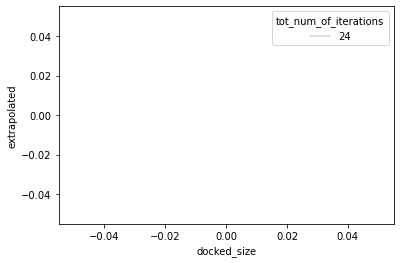

In [140]:
df_plot = df_facetgrid.copy(deep=True).query("tot_num_of_iterations == 24")

# ax = sns.lineplot(
    # data=df_plot,
    # x="docked_size",
    # y="percentage_of_hits",
    # hue="tot_num_of_iterations",
    # color="gray",
# )

sns.lineplot(
    data=df_plot,
    x="docked_size",
    y="extrapolated",
    hue="tot_num_of_iterations",
    color="red",
)

/tmp/ipykernel_94951/4284195388.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)
/tmp/ipykernel_94951/4284195388.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)
/tmp/ipykernel_94951/4284195388.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)
/tmp/ipykernel_94951/4284195388.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)
/tmp/ipykernel_94951/4284195388.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)
/tmp/ipykernel_94951/4284195388.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45

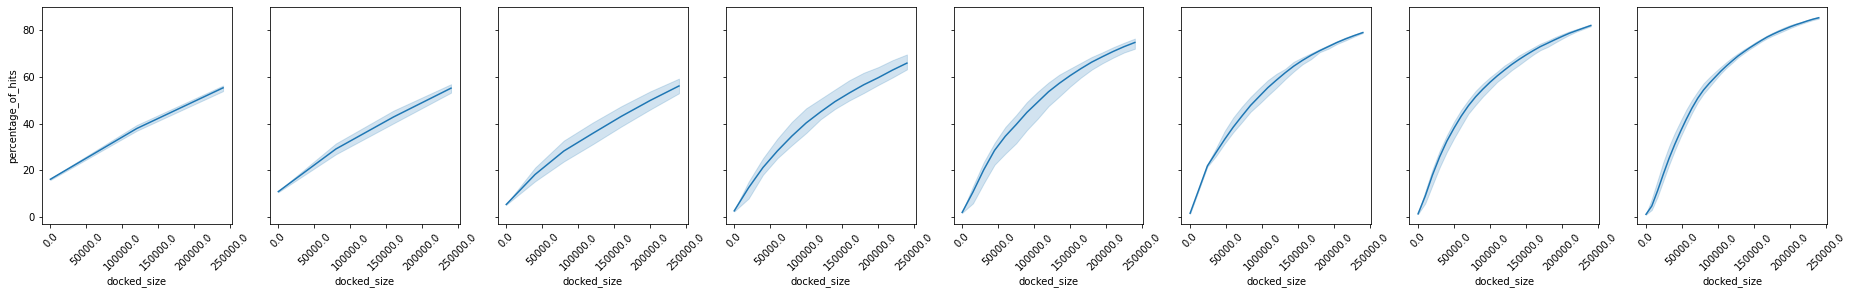

In [89]:
num_of_subplots = len(subdf.tot_num_of_iterations.unique())
fig, axs = plt.subplots(
    nrows=1,
    ncols=num_of_subplots,
    sharey=True,
    sharex=True,
    figsize=(4 * num_of_subplots, 4),
)

possible_iteration_nums = sorted(subdf.tot_num_of_iterations.unique())

for ax, num_of_iterations in zip(axs, possible_iteration_nums):
    data = subdf.query(f"tot_num_of_iterations == {num_of_iterations}")
    sns.lineplot(
        data=data,
        x="docked_size",
        y="percentage_of_hits",
        palette="viridis",
        ax=ax,
    )
    ax.set_xticklabels(ax.get_xticks(), rotation=45)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

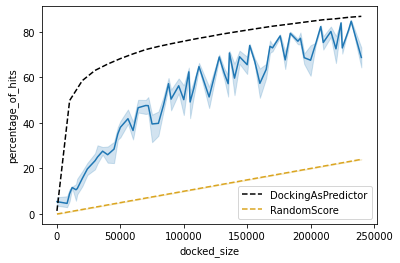

In [79]:
# all linear regression plots
ax = sns.lineplot(
    data=subdf,
    x="docked_size",
    y="percentage_of_hits",
    palette="viridis",
)

# baseline DockingAsPredictor -- upper bond
sns.lineplot(
    ax=ax,
    data=(
        df.query('model == "DockingAsPredictor"').query("tot_num_of_iterations == 24")
    ),
    x="docked_size",
    y="percentage_of_hits",
    color="black",
    linestyle="--",
    label="DockingAsPredictor",
)

# baseline "RandomScore" -- lower bond
sns.lineplot(
    ax=ax,
    data=df,
    x="docked_size",
    y="baseline",
    color="goldenrod",
    linestyle="--",
    label="RandomScore",
)

# add extrapolated values

for _, row in df_performance.iterrows():
    f = row2function(row)
    subdf["extrapolated_percentage"] = f(subdf.docked_size)

# modify legend
for text in ax.get_legend().get_texts():
    new_texts = []
    if text.get_text() != "True":
        new_texts.append(text.get_text())
ax.set_title(f"Dataset: {dataset}")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Plot the graphs

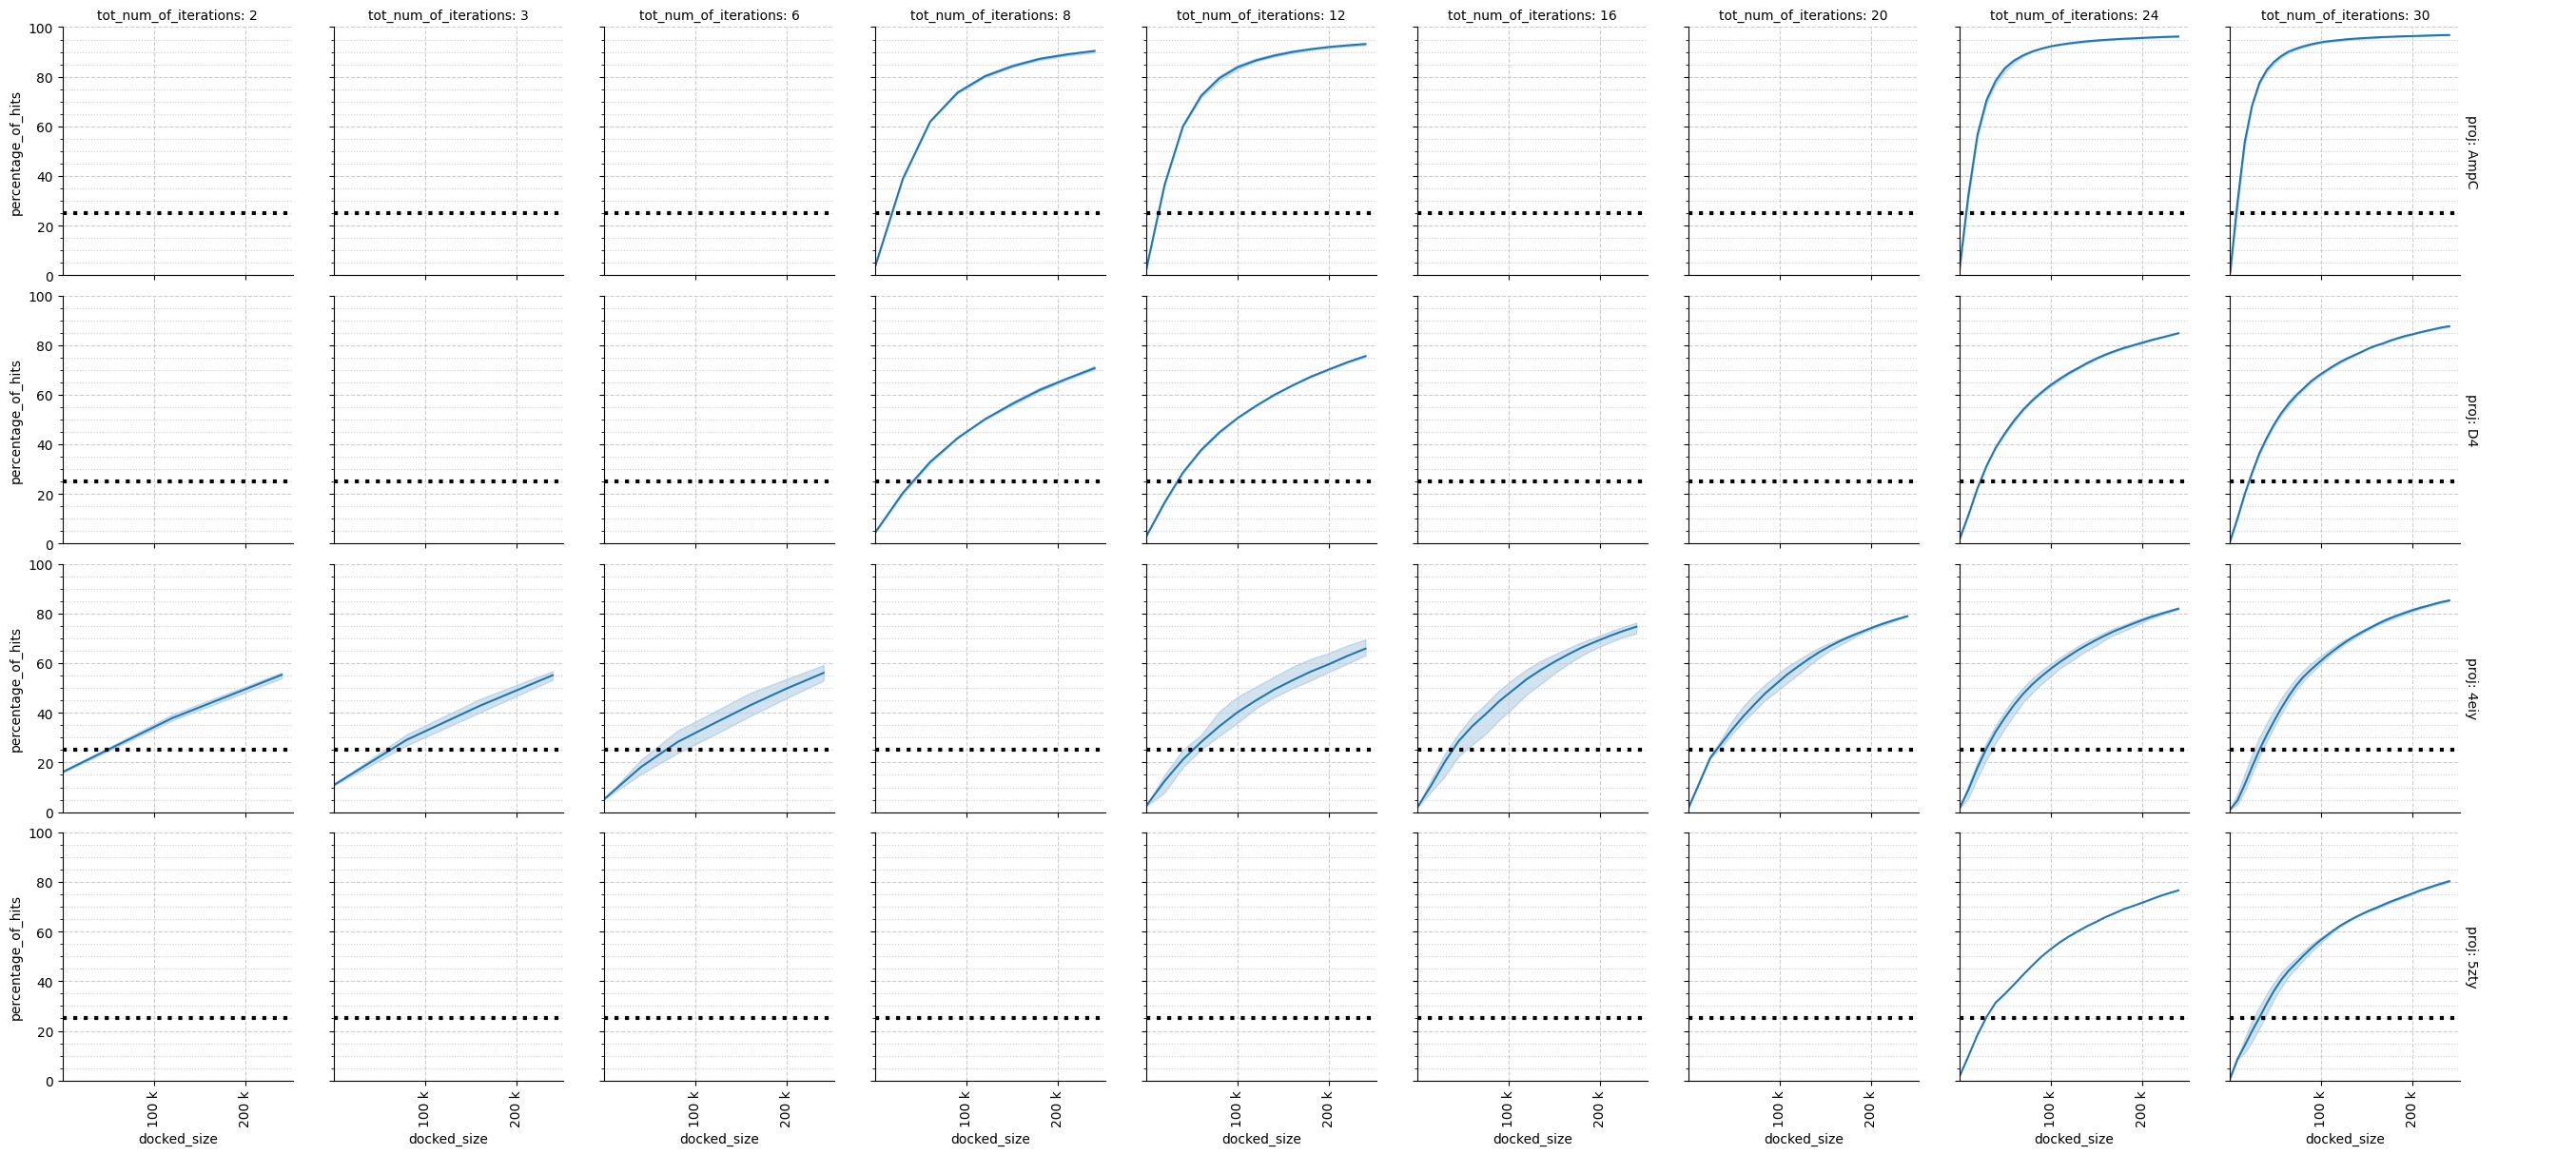

In [49]:
regressors = ["LinearRegression"]
colors = sns.color_palette("colorblind", n_colors=len(regressors))
palette = {tag: color for tag, color in zip(regressors, colors)}

kwa = {
    "x": "docked_size",
    "y": "percentage_of_hits",
    #     'hue': "model",
    #     'style':'add_to_train'
}

col = "tot_num_of_iterations"
row = "proj"

grid = sns.FacetGrid(df, col=col, row=row, margin_titles=True, sharex=True, sharey=True)
(
    grid.map_dataframe(sns.lineplot, **kwa, palette=palette)
    #  .set(xscale = 'log')
)

for ax in grid.axes.flat:
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))

    ax.set_ylim(0, 100)
    ax.grid(which="major", color="#CCCCCC", linestyle="--")
    ax.grid(which="minor", color="#CCCCCC", linestyle=":")

    ax.set_xlim(1, None)
    ax.axhline(25, color="black", linestyle=":", linewidth=3.0)

    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    plt.setp(ax.get_xticklabels(), rotation=90)

grid.set_titles(
    row_template="%s: {row_name}" % row, col_template="%s: {col_name}" % col
)
grid.add_legend()

# plt.savefig('../figures/Figure_3_4eiy.png')
plt.show()

# Make sure we know which model is the best for 4eiy

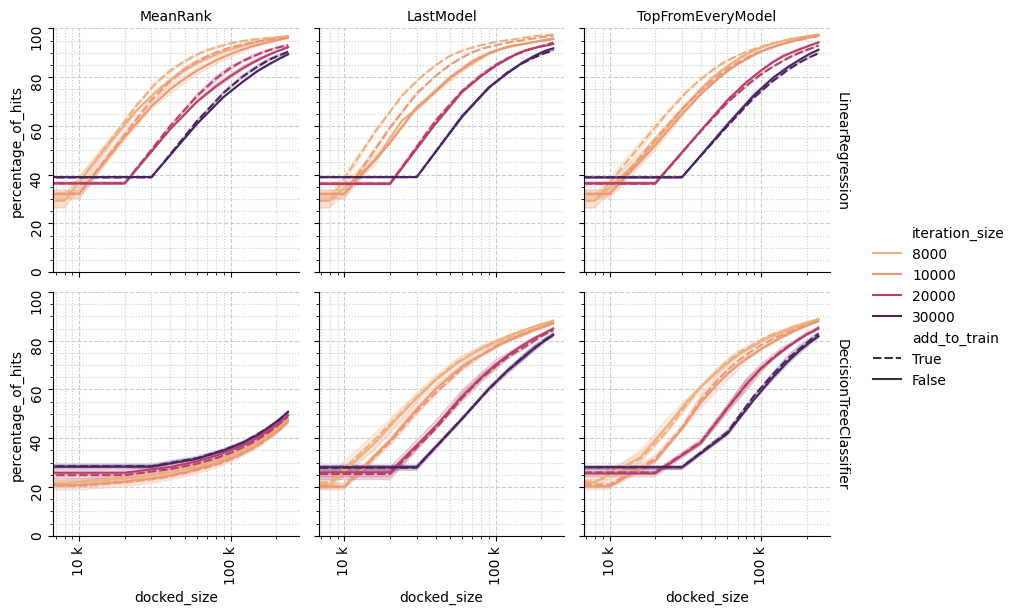

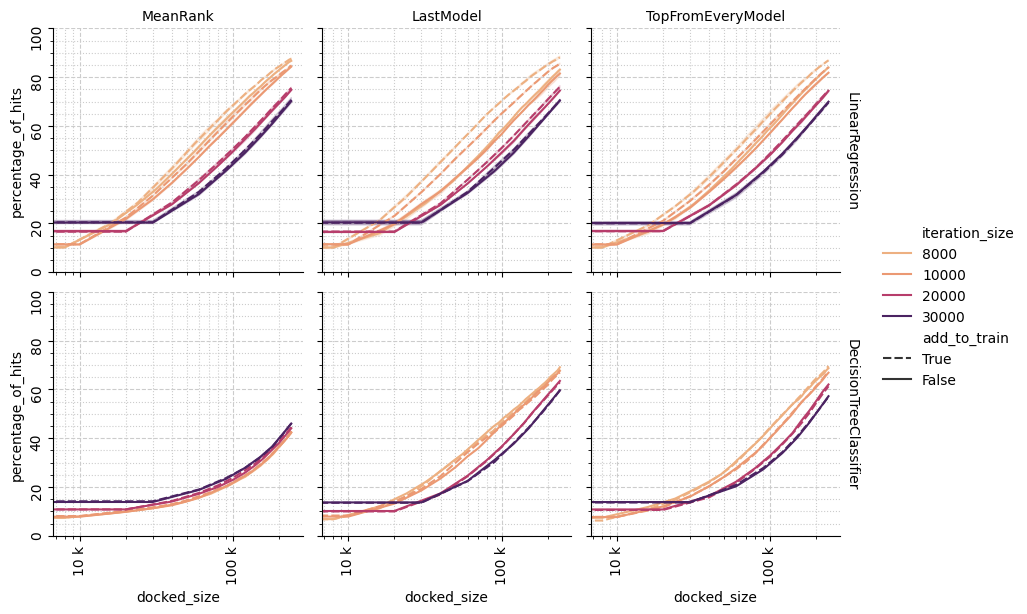

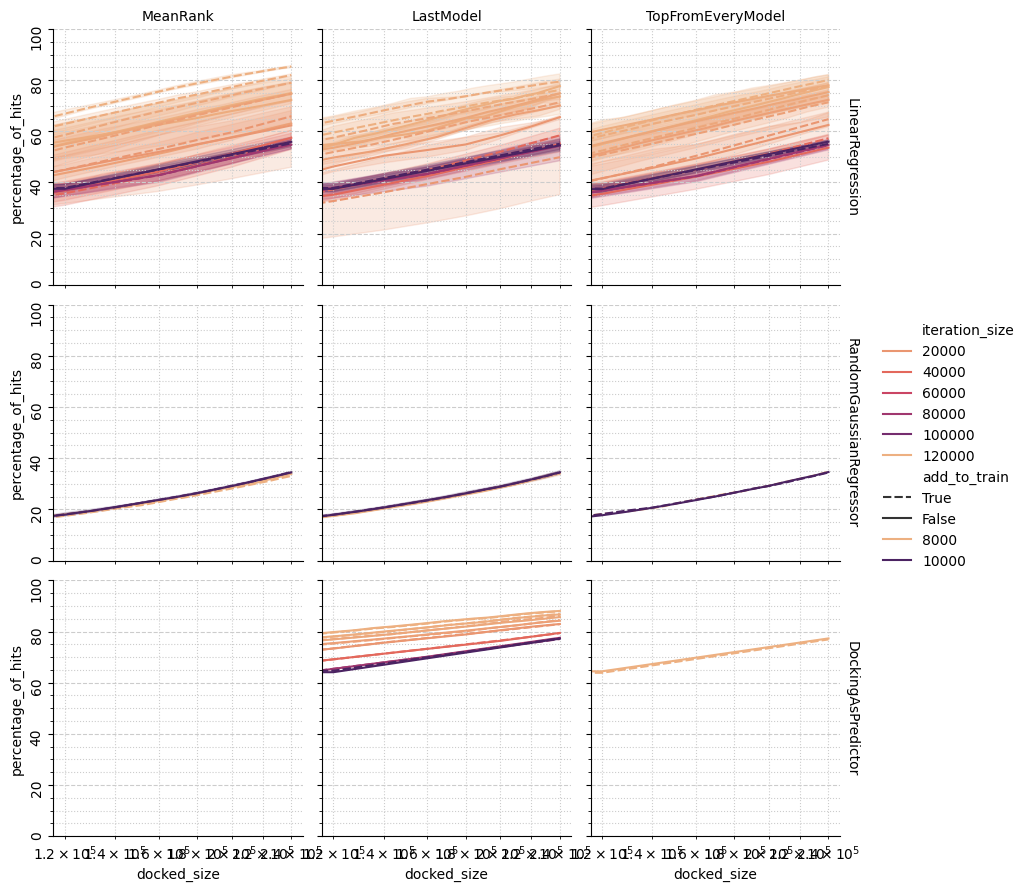

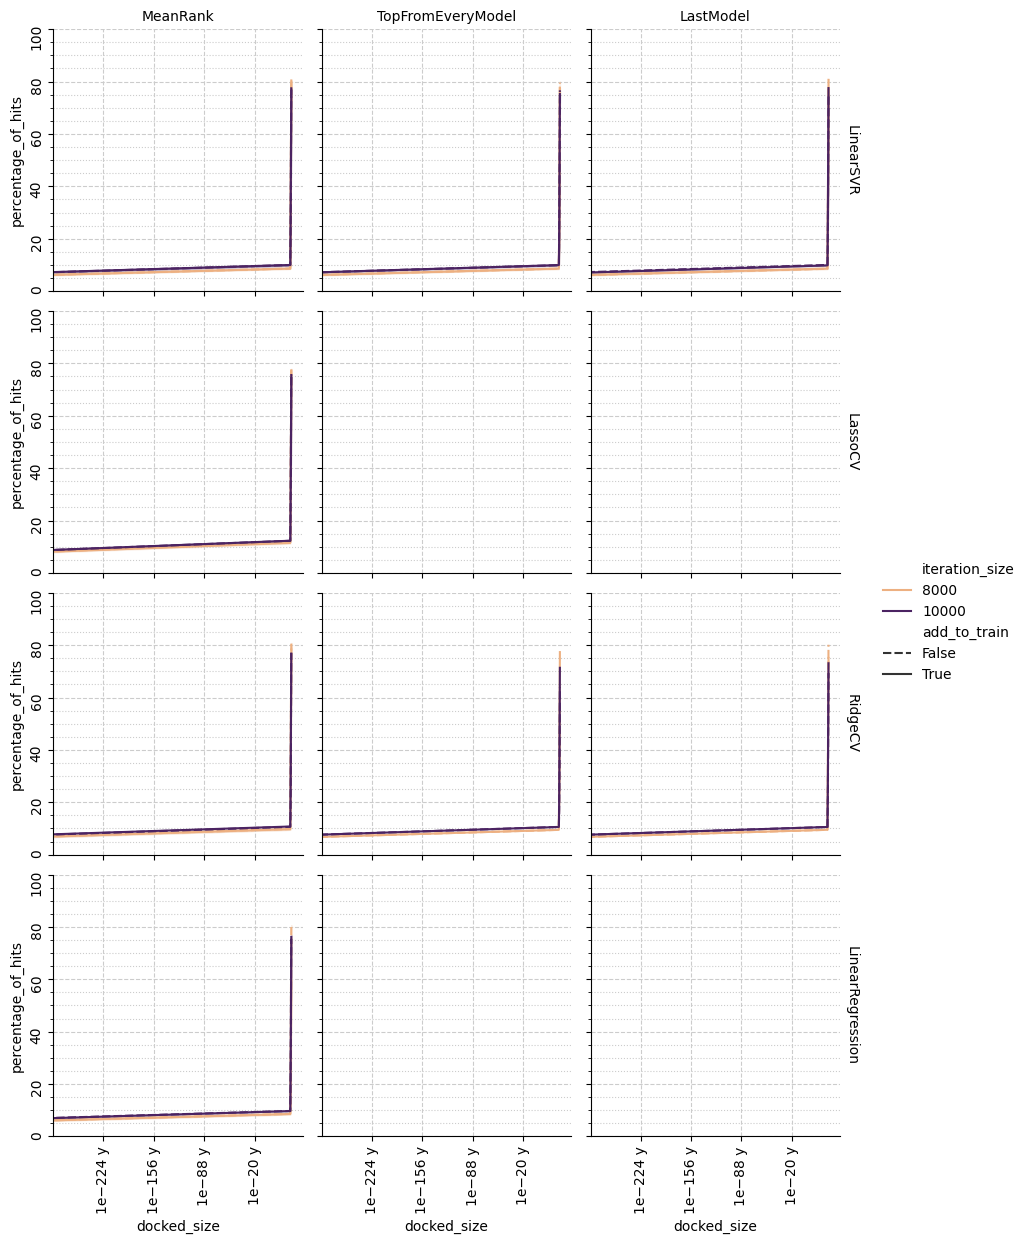

In [84]:
for proj in datasets:
    df = (
        raw_data.reset_index()
        .replace({"add": "True", "noadd": "False"})
        #       .query("type == 'regressor'")
        #       .query("add_to_train == 'False'")
        #       .query("prediction_method == 'MeanRank'")
        .pipe(add_iteration_size)
        .assign(model_and_proj=lambda df: df.proj + "_" + df.model)
        #       .assign(tot_num_of_iterations = lambda df: df.tot_num_of_iterations + 1)
        .query(f"proj == '{proj}'")
    )

    kwa = {
        "x": "docked_size",
        "y": "percentage_of_hits",
        "hue": "iteration_size",
        "style": "add_to_train",
    }

    grid = sns.FacetGrid(df, row="model", col="prediction_method", margin_titles=True)
    (grid.map_dataframe(sns.lineplot, **kwa, palette="flare").set(xscale="log"))

    for ax in grid.axes.flat:
        ax.xaxis.set_major_formatter(ticker.EngFormatter())
        ax.yaxis.set_minor_locator(AutoMinorLocator(4))

        ax.set_ylim(0, 100)
        ax.grid(which="major", color="#CCCCCC", linestyle="--")
        ax.grid(which="minor", color="#CCCCCC", linestyle=":")
        #     ax.set_xlim(1,None)
        plt.setp(ax.get_yticklabels(), rotation=90)
        plt.setp(ax.get_xticklabels(), rotation=90)

    grid.set_titles(row_template="{row_name}", col_template="{col_name}")
    grid.add_legend()

    plt.savefig(f"../figures/Figure_3_{proj}_models.png")
    plt.show()

# Test the first iteration only

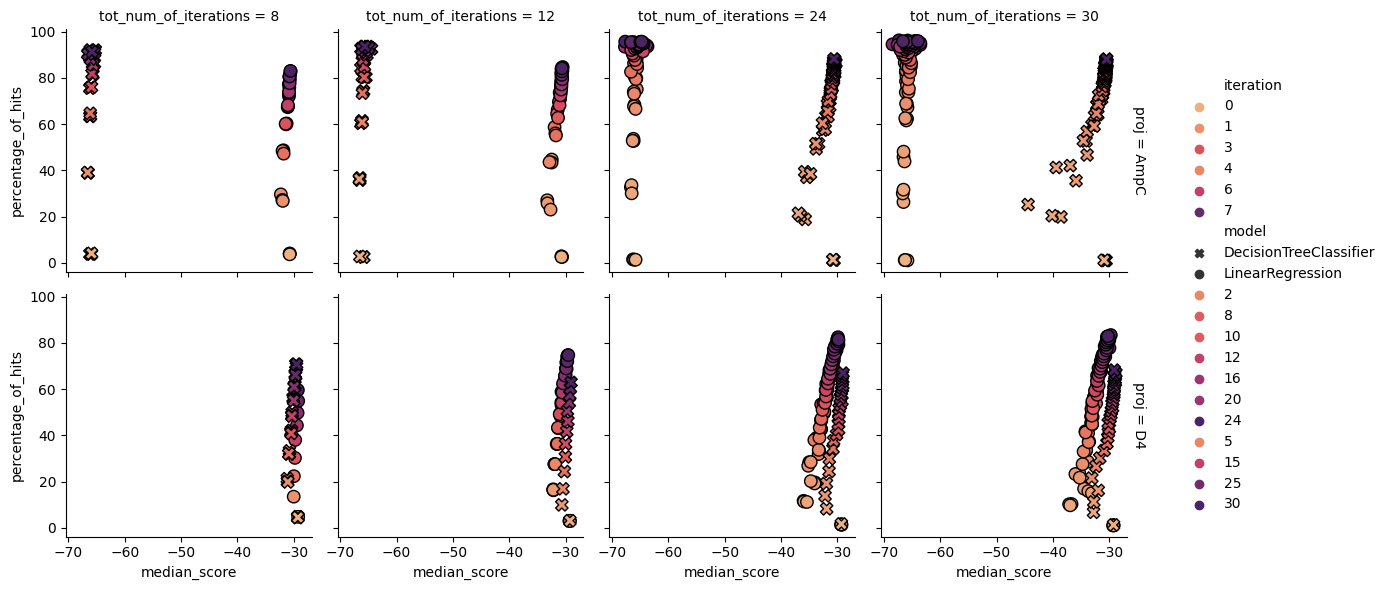

In [164]:
df = (
    raw_data.reset_index()
    .replace({"add": "True", "noadd": "False"})
    .pipe(add_iteration_size)
    .query("add_to_train == 'False'")
    .query("prediction_method == 'LastModel'")
    .assign(model_and_proj=lambda df: df.proj + "_" + df.model)
    #       .query('iteration == 1')
    #       .query("proj == 'D4'")
)

kwa = {
    #     'x' : "log2_time_sec",
    "x": "median_score",
    "y": "percentage_of_hits",
    "style": "model",
    "hue": "iteration",
    "edgecolor": "k",
    "linewidth": 1,
    "s": 80,
}

grid = sns.FacetGrid(df, col="tot_num_of_iterations", row="proj", margin_titles=True)
(
    grid.map_dataframe(sns.scatterplot, **kwa, palette="flare")
    #  .set(xscale = 'log')
)

grid.add_legend()
# plt.savefig('../figures/Figure_4.png')
plt.show()

In [100]:
raw_data.prediction_method.unique()

array(['MeanRank', 'LastModel', 'TopFromEveryModel'], dtype=object)

# Look at the median docking score as well

In [142]:
df = (
    raw_data.reset_index()
    .replace({"add": "True", "noadd": "False"})
    .pipe(add_iteration_size)
    #       .query("add_to_train == 'False'")
    .query("model == 'LinearRegression'")
    #       .query("prediction_method == 'TopFromEveryModel'")
    .assign(model_and_proj=lambda df: df.proj + "_" + df.model)
    #       .query('iteration == 1')
    .query("proj == '4eiy'")
)

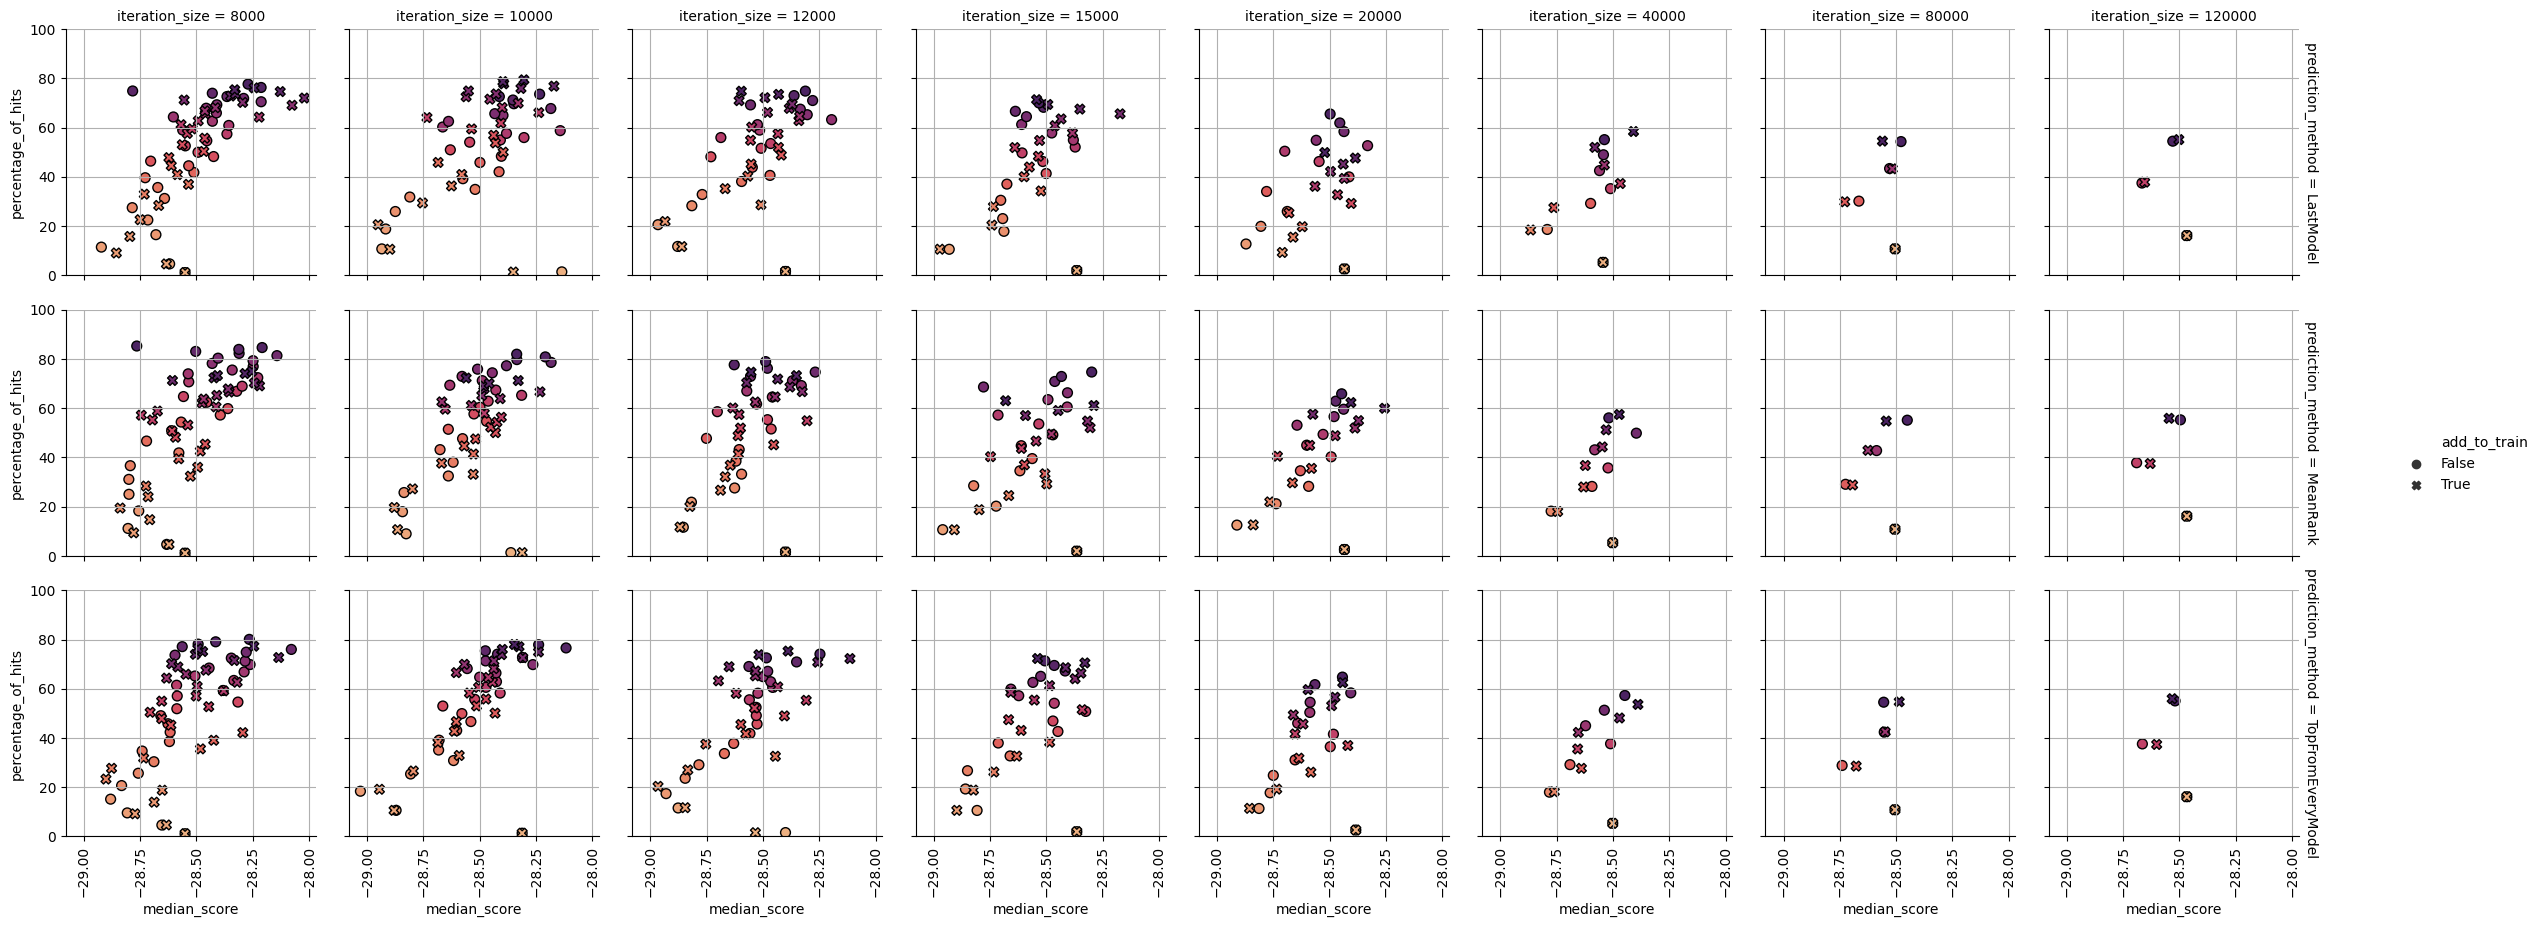

In [165]:
df = (
    raw_data.reset_index()
    .replace({"add": "True", "noadd": "False"})
    .pipe(add_iteration_size)
    #       .query("add_to_train == 'False'")
    .query("model == 'LinearRegression'")
    #       .query("prediction_method == 'TopFromEveryModel'")
    .assign(model_and_proj=lambda df: df.proj + "_" + df.model)
    #       .query('iteration == 1')
    .query("proj == '4eiy'")
    .groupby(
        [
            "add_to_train",
            "prediction_method",
            "iteration_size",
            "docked_size",
            "iteration",
        ]
    )
    .agg("mean")
    .loc[:, ["median_score", "percentage_of_hits"]]
    .reset_index()
)

kwa = {
    #     'x' : "log2_time_sec",
    "x": "median_score",
    "y": "percentage_of_hits",
    "style": "add_to_train",
    "hue": "iteration",
    "edgecolor": "k",
    "linewidth": 2,
    "s": 50,
    #     'legend':False
}

grid = sns.FacetGrid(
    df,
    col="iteration_size",
    row="prediction_method",
    margin_titles=True,
    sharex=True,
    sharey=True,
)

(
    grid.map_dataframe(sns.scatterplot, **kwa, palette="flare")
    #  .set(xscale = 'log')
)

for ax in grid.axes.flat:
    ax.grid()
    ax.set_ylim(0, 100)
    plt.setp(ax.get_xticklabels(), rotation=90)

included_labels = ["True", "False", "add_to_train"]
grid.add_legend(
    legend_data={k: v for k, v in grid._legend_data.items() if k in included_labels}
)
# plt.savefig('../figures/Figure_3.png')
plt.show()

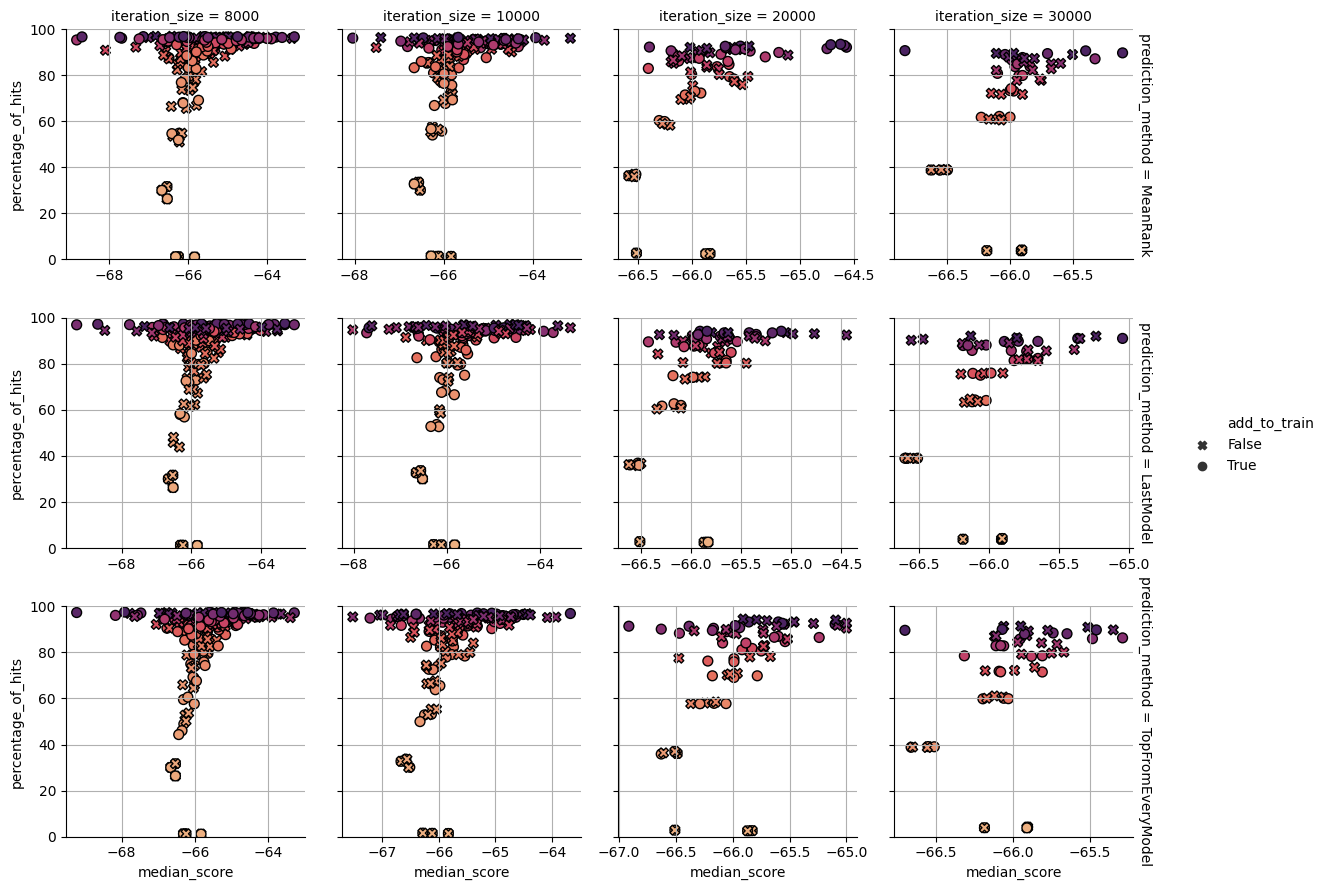

In [26]:
df = (
    raw_data.reset_index()
    .replace({"add": "True", "noadd": "False"})
    .pipe(add_iteration_size)
    #       .query("add_to_train == 'False'")
    .query("type == 'regressor'")
    #       .query("prediction_method == 'TopFromEveryModel'")
    .assign(model_and_proj=lambda df: df.proj + "_" + df.model)
    #       .query('iteration == 1')
    .query("proj == 'AmpC'")
)

kwa = {
    #     'x' : "log2_time_sec",
    "x": "median_score",
    "y": "percentage_of_hits",
    "style": "add_to_train",
    "hue": "iteration",
    "edgecolor": "k",
    "linewidth": 1,
    "s": 50,
    #     'legend':False
}

grid = sns.FacetGrid(
    df, col="iteration_size", row="prediction_method", margin_titles=True, sharex=False
)

(
    grid.map_dataframe(sns.scatterplot, **kwa, palette="flare")
    #  .set(xscale = 'log')
)

for ax in grid.axes.flat:
    ax.grid()
    ax.set_ylim(0, 100)

included_labels = ["True", "False", "add_to_train"]
grid.add_legend(
    legend_data={k: v for k, v in grid._legend_data.items() if k in included_labels}
)
# plt.savefig('../figures/Figure_4.png')
plt.show()